# Wind data

## Import libraries

In [58]:
"""Basic ones"""
import polars as pl
from plotnine import *
import matplotlib.pyplot as plt
plt.show()  # for display figures after ggplot
plt.style.use("ggplot")
# plt.rcParams['axes.grid'] = True
import numpy as np
import seaborn as sns
import pandas
import statsmodels.api as sm
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

## Load data

風速の表し方には「平均風速」と「瞬間風速」があります。気象台が気象情報等で「風速」という場合は「10分間平均風速」のことであり、「瞬間風速」という場合は「3 秒間平均風速」のことです。また、それぞれの最大値を「最大風速」及び「最大瞬間風速」といいます。瞬間風速は、平均風速の1.5 倍から2 倍、ときには3倍以上となる場合もあります。下記は、今年9月7日に台風第10号が接近した際、県内のアメダスで観測した最大瞬間風速とその時間帯における平均風速です（いずれも速報値）。 ([Ref.](https://jma-net.go.jp/matsuyama/publication/tenko/tenko202010.pdf))

- 平均風速(m/s)
- 最大風速(m/s)
- ~~最大風速(m/s)時分~~
- ~~最大風速(m/s)風向~~
- 最大瞬間風速(m/s)
- ~~最大瞬間風速(m/s)時分~~
- ~~最大瞬間風速(m/s)風向~~
- 最多風向(16方位)

In [59]:
file_name = "../../data/weather/wind.csv"
df = pl.read_csv(file_name, encoding="shift-jis", skip_rows=3)
display(df.columns)
df.columns = ["date", "day_of_week", "mean_wind_speed", "max_wind_speed", "max_wind_speed_time", \
                "max_wind_speed_direction", "max_gust", "max_gust_time", \
                    "max_gust_direction", "most_direction"]
df = df.with_columns(pl.col("date").str.strptime(pl.Date, "%Y/%m/%d")) # convert day column data type into date type
df = (
    df.with_columns(pl.col(["max_wind_speed_time", "max_gust_time"]).str
                    .strptime(pl.Datetime, "%Y/%m/%d %H:%M")) # convert time column data type into datetime
)
df.head()

['年月日',
 '曜日',
 '平均風速(m/s)',
 '最大風速(m/s)',
 '最大風速(m/s)時分',
 '最大風速(m/s)風向',
 '最大瞬間風速(m/s)',
 '最大瞬間風速(m/s)時分',
 '最大瞬間風速(m/s)風向',
 '最多風向(16方位)']

date,day_of_week,mean_wind_speed,max_wind_speed,max_wind_speed_time,max_wind_speed_direction,max_gust,max_gust_time,max_gust_direction,most_direction
date,str,f64,f64,datetime[μs],str,f64,datetime[μs],str,str
2017-07-01,"""土""",1.5,3.8,2017-07-01 15:07:00,"""西北西""",6.2,2017-07-01 23:57:00,"""南西""","""南南東"""
2017-07-02,"""日""",1.8,5.7,2017-07-02 11:34:00,"""北北西""",9.6,2017-07-02 13:37:00,"""西北西""","""北東"""
2017-07-03,"""月""",2.2,6.3,2017-07-03 17:39:00,"""西北西""",11.3,2017-07-03 17:20:00,"""北西""","""北"""
2017-07-04,"""火""",1.2,3.6,2017-07-04 01:01:00,"""北北西""",5.3,2017-07-04 00:59:00,"""北北西""","""北"""
2017-07-05,"""水""",2.8,6.7,2017-07-05 14:13:00,"""北北西""",9.8,2017-07-05 14:09:00,"""北北西""","""北西"""


In [60]:
# https://www.data.jma.go.jp/suishin/shiyou/pdf/no13302
direction = ["北", "北北東", "北東", "東北東", "東", "東南東", "南東", "南南東", "南", \
                "南南西", "南西", "西南西", "西", "西北西", "北西", "北北西"]
direction_eng = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", \
                "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
direction_eng_dict = {jpn: eng for jpn, eng in zip(direction, direction_eng)}
direction_dict = {dire: idx+1 for idx, dire in enumerate(direction)}
df = df.with_columns(
    pl.col("most_direction").replace(direction_dict, return_dtype=pl.Int8).alias("most_direction_dummy"),
    # pl.col("most_direction").apply(lambda dire: direction_dict[dire]).alias("most_direction_dummy") # map_elements
    pl.col("most_direction").replace(direction_eng_dict, return_dtype=pl.String).alias("most_direction")
)
df.head()

date,day_of_week,mean_wind_speed,max_wind_speed,max_wind_speed_time,max_wind_speed_direction,max_gust,max_gust_time,max_gust_direction,most_direction,most_direction_dummy
date,str,f64,f64,datetime[μs],str,f64,datetime[μs],str,str,i8
2017-07-01,"""土""",1.5,3.8,2017-07-01 15:07:00,"""西北西""",6.2,2017-07-01 23:57:00,"""南西""","""SSE""",8
2017-07-02,"""日""",1.8,5.7,2017-07-02 11:34:00,"""北北西""",9.6,2017-07-02 13:37:00,"""西北西""","""NE""",3
2017-07-03,"""月""",2.2,6.3,2017-07-03 17:39:00,"""西北西""",11.3,2017-07-03 17:20:00,"""北西""","""N""",1
2017-07-04,"""火""",1.2,3.6,2017-07-04 01:01:00,"""北北西""",5.3,2017-07-04 00:59:00,"""北北西""","""N""",1
2017-07-05,"""水""",2.8,6.7,2017-07-05 14:13:00,"""北北西""",9.8,2017-07-05 14:09:00,"""北北西""","""NW""",15


## Check nulls

In [61]:
display(df.null_count())

nulls = df.hstack(df.transpose().select(pl.all().is_null().sum()).transpose().rename({"column_0": "null_count"}))
nulls.filter(pl.col("null_count") != 0)

date,day_of_week,mean_wind_speed,max_wind_speed,max_wind_speed_time,max_wind_speed_direction,max_gust,max_gust_time,max_gust_direction,most_direction,most_direction_dummy
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,4,4,4,4,4,4,4,4,4


date,day_of_week,mean_wind_speed,max_wind_speed,max_wind_speed_time,max_wind_speed_direction,max_gust,max_gust_time,max_gust_direction,most_direction,most_direction_dummy,null_count
date,str,f64,f64,datetime[μs],str,f64,datetime[μs],str,str,i8,u32
2020-03-29,"""日""",null,null,null,null,null,null,null,null,null,9
2021-01-05,"""火""",null,null,null,null,null,null,null,null,null,9
2022-02-11,"""金""",null,null,null,null,null,null,null,null,null,9
2024-02-06,"""火""",null,null,null,null,null,null,null,null,null,9


## Visualization

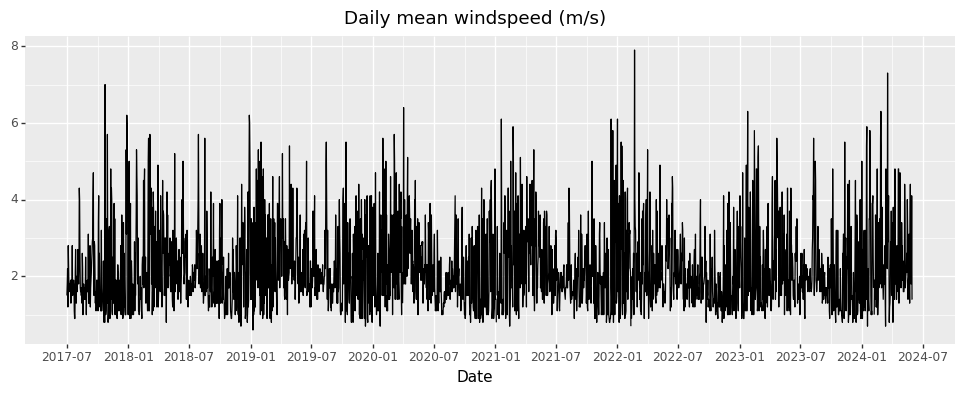

<ggplot: (8732666900646)>

In [62]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_wind_speed"))
    + labs(title="Daily mean windspeed (m/s)", x="Date", y="")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

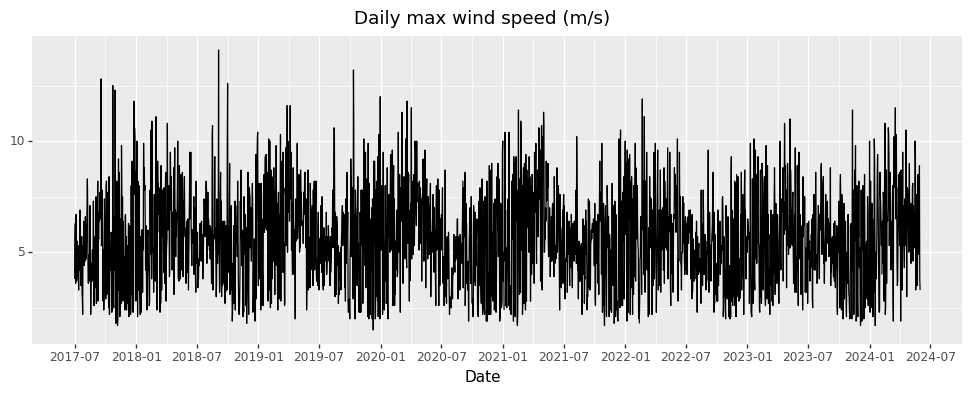

<ggplot: (8732668666887)>

In [63]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="max_wind_speed"))
    + labs(title="Daily max wind speed (m/s)", x="Date", y="")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

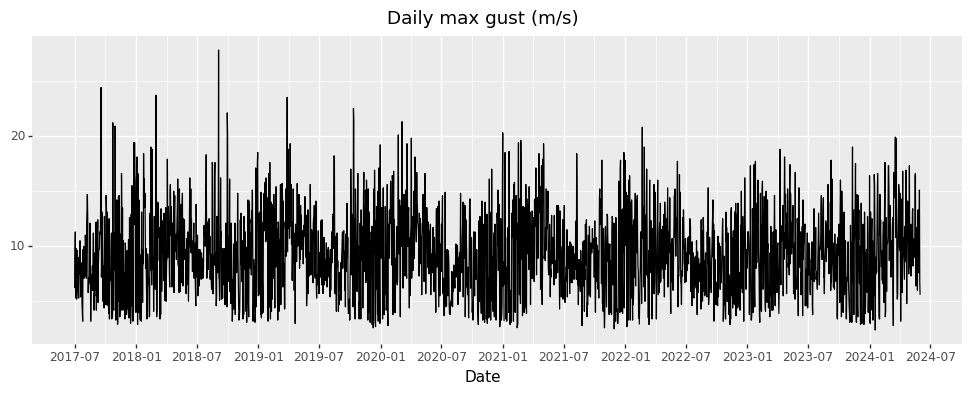

<ggplot: (8732658307069)>

In [64]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="max_gust"))
    + labs(title="Daily max gust (m/s)", x="Date", y="")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

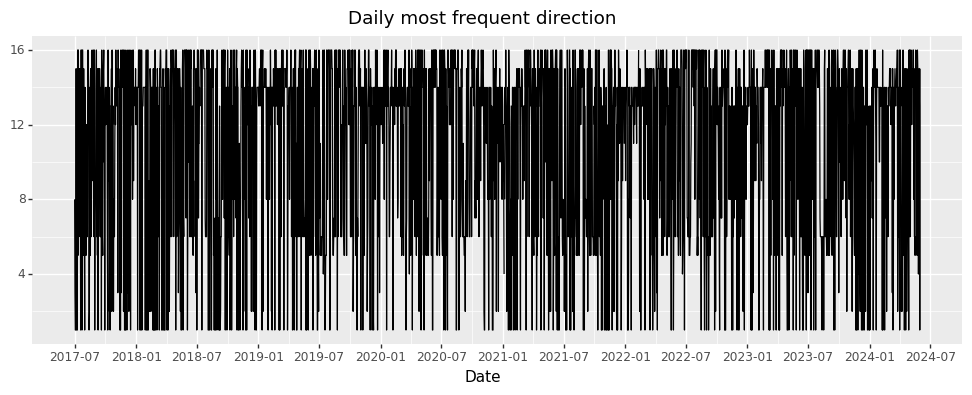

<ggplot: (8732658080438)>

In [65]:
(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="most_direction_dummy"))
    + labs(title="Daily most frequent direction", x="Date", y="")
    + theme(figure_size=(12, 4))
    + scale_x_date(
    #     limits=(
    #         datetime(year=2018, month=1, day=1),
    #         datetime(year=2022, month=1, day=1)
    #     ),
        date_labels="%Y-%m",
        date_breaks="6 month",
    #     # expand=(0, 1),
    #     date_minor_breaks="1 month",
    )
)

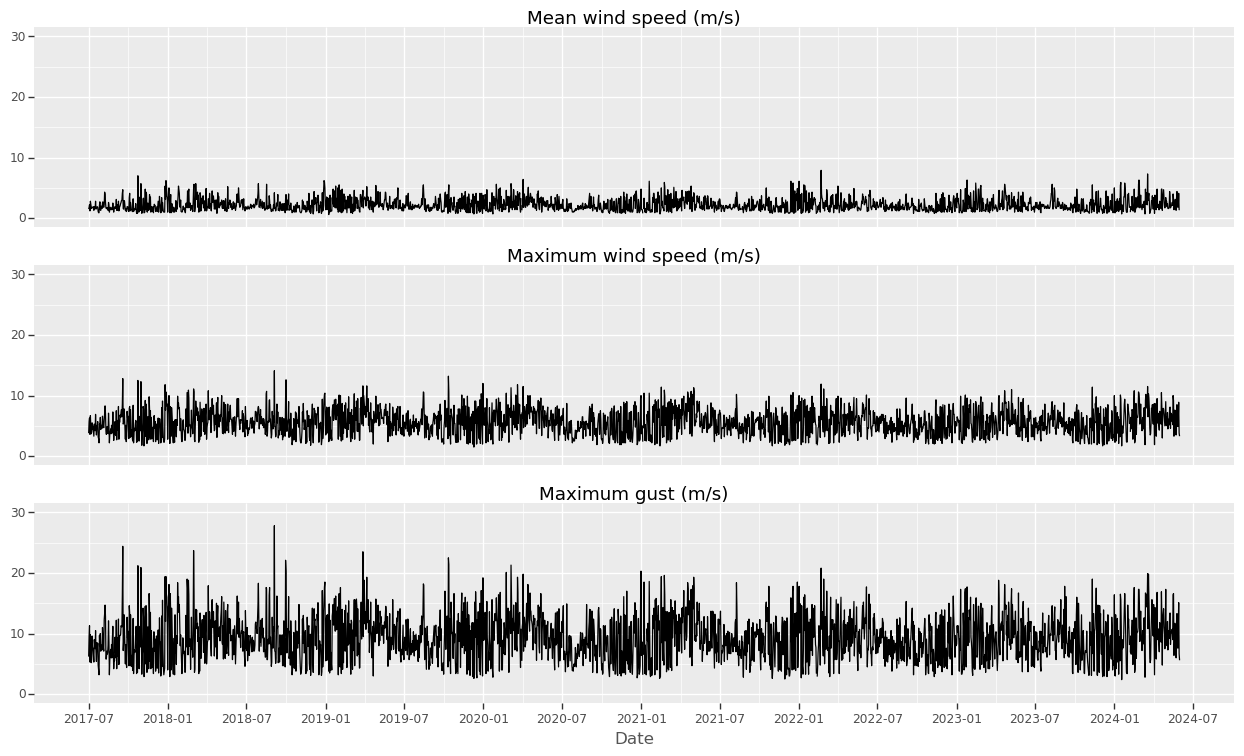

In [66]:
# https://github.com/has2k1/plotnine/issues/46
import patchworklib as pw

g1 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="mean_wind_speed"))
    + labs(title="Mean wind speed (m/s)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(0, 30)
)

g2 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="max_wind_speed"))
    + labs(title="Maximum wind speed (m/s)", x="Date", y="")
    + theme(figure_size=(12, 2), axis_title_x=element_blank(), axis_ticks_major_x=element_blank()
            , axis_ticks_minor_x=element_blank(), axis_text_x=element_blank())
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(0, 30)
)

g3 = pw.load_ggplot(
    ggplot(data=df, mapping=aes(x="date"))
    + geom_line(aes(y="max_gust"))
    + labs(title="Maximum gust (m/s)", x="Date", y="")
    + theme(figure_size=(12, 2))
    + scale_x_date(
        date_labels="%Y-%m",
        date_breaks="6 month",
    )
    + ylim(0, 30)
)

# By specifying g3 in (g3|g2), g1 is positioned exactly on g3.
pw.param["margin"] = 0.2
(
    g1 / g2 / g3
).savefig(fname="../../fig/weather/wind.png", dpi=500)

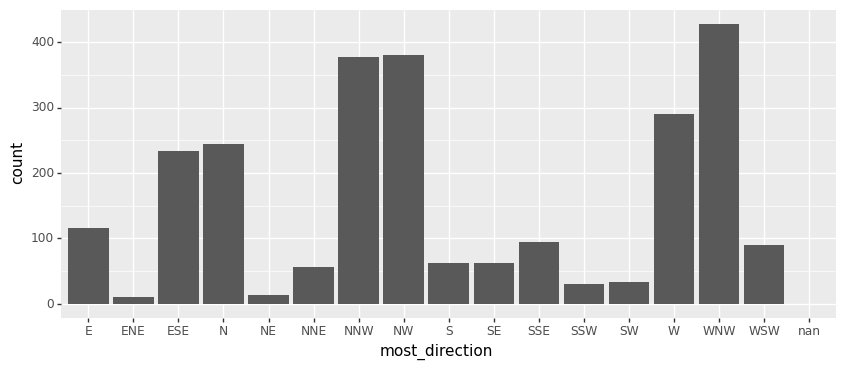

<ggplot: (8732657097533)>

In [78]:
(
    ggplot(df)
    + geom_bar(aes("most_direction"))
    + theme(figure_size=(10, 4))
)

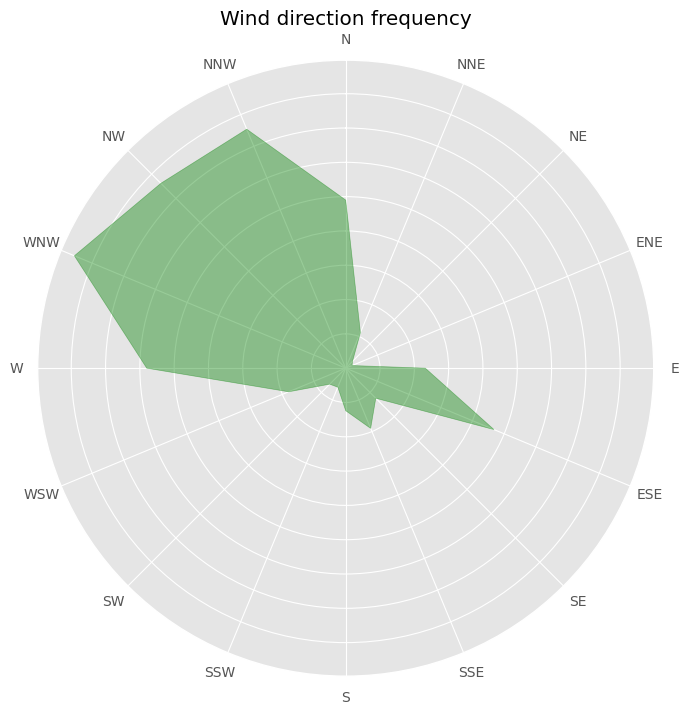

In [96]:
# 風向の頻度を計算
hist, _ = np.histogram(df["most_direction_dummy"].drop_nulls(), bins=len(direction))

# 極座標プロットの作成
angles = np.linspace(0, 2 * np.pi, len(hist), endpoint=False).tolist()
angles += angles[:1]  # 完全な円を作成するために最初の値を再度追加

hist = np.append(hist, hist[0])  # 完全な円を作成するために最初の値を再度追加

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, hist, color="green", alpha=0.4)
ax.set_yticklabels("")
ax.set_xticks(angles[:-1])
ax.set_xticklabels(direction_eng)

# 0が一番上になるように設定
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)  # 時計回りに設定（オプション）

plt.title("Wind direction frequency");